In [2]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

# # import pickle file 
with open('../scenario-properties-test.pkl', 'rb') as f:
    baseline = pickle.load(f)

# with open('../scenario-properties-controller_orig.pkl', 'rb') as f:
#     baseline = pickle.load(f)


# "mass": [0.0156, 0.5, 1],
#             "radius": [0.0625, 0.125, 0.25],

# "mass": [0.0156, 0.5, 1, 8],
#             "radius": [0.0625, 0.125, 0.25, 0.5],


# ,
#         {
#             "sym_name": "D",
#             "Cd": 2.2,
#             "mass": 200,
#             "A": 5,
#             "radius": 1.25,
#             "active": false,
#             "maneuverable": false,
#             "trackable": false,
#             "deltat": null,
#             "Pm": 0,
#             "alpha": 0,
#             "alpha_active": 0,
#             "RBflag": 0,
#             "slotting_effectiveness": 0,
#             "drag_effected": true,
#             "launch_func": "launch_func_null",
#             "pmd_func": "pmd_func_none",
#             "drag_func": "drag_func_exp"
#         }

# ## Constraints for trust-constr: lb <= fun(x) <= ub
# nonlcon = NonlinearConstraint(lambda x: PrcAll(x, baseline), 0, 0)
# # # nonlcon = NonlinearConstraint(lambda x: PrcAll(x, baseline), 0, 1e-8)
# ## Options for trust-constr
# options = {
#     'disp': True,           
#     # 'maxiter': 5e5,       
#     # 'xtol': 1e-18,           
#     'gtol': 1e1,
# }

In [3]:
# Equations
baseline.equations

# x0 initial population
baseline.x0

# baseline.
baseline.all_symbolic_vars

# solver
equations_flattened = [baseline.equations[i, j] for j in range(baseline.equations.cols) for i in range(baseline.equations.rows)]

full_lambda = sp.Matrix(sp.symbols([f'lambda_{i+1}' for i in range(baseline.n_shells)]))
full_lambda_flattened = [full_lambda[i, j] for j in range(full_lambda.cols) for i in range(full_lambda.rows)]

for i1 in range(baseline.n_shells):
    equations_flattened[i1] = equations_flattened[i1]+full_lambda_flattened[i1]

baseline.all_symbolic_vars = baseline.all_symbolic_vars + full_lambda_flattened

equations = [sp.lambdify(baseline.all_symbolic_vars, eq, 'numpy') for eq in equations_flattened]

In [3]:
# P = 0.9; 
# alpha = 0.2; 
# alpha_active = 0.1;
# delta = 0;
# Dt = 8;
# mass      = [192.9379  192.9379   16.9068];      
# Area         = [4.9564    4.9564    0.4952];
# diameter  = [2.5121    2.5121    0.7941];

lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8, lambda_9, lambda_10, lambda_11, lambda_12, lambda_13, lambda_14 = sp.symbols('lambda_1 lambda_2 lambda_3 lambda_4 lambda_5 lambda_6 lambda_7 lambda_8 lambda_9 lambda_10 lambda_11 lambda_12 lambda_13 lambda_14')
S_1, S_2, S_3, S_4, S_5, S_6, S_7, S_8, S_9, S_10, S_11, S_12, S_13, S_14 = sp.symbols('S_1 S_2 S_3 S_4 S_5 S_6 S_7 S_8 S_9 S_10 S_11 S_12 S_13 S_14')
N_1, N_2, N_3, N_4, N_5, N_6, N_7, N_8, N_9, N_10, N_11, N_12, N_13, N_14 = sp.symbols('N_1 N_2 N_3 N_4 N_5 N_6 N_7 N_8 N_9 N_10 N_11 N_12 N_13 N_14')
D_1, D_2, D_3, D_4, D_5, D_6, D_7, D_8, D_9, D_10, D_11, D_12, D_13, D_14 = sp.symbols('D_1 D_2 D_3 D_4 D_5 D_6 D_7 D_8 D_9 D_10 D_11 D_12 D_13 D_14')

full_lambda = sp.Matrix(sp.symbols([f'lambda_{i+1}' for i in range(baseline.n_shells)]))
full_lambda_flattened = [full_lambda[i, j] for j in range(full_lambda.cols) for i in range(full_lambda.rows)]
baseline.all_symbolic_vars = baseline.all_symbolic_vars + full_lambda_flattened

mocat3 = [lambda_1 - S_1/8 - (3736148020190767*N_1*S_1)/188894659314785808547840 - (3451116821312583*S_1**2)/151115727451828646838272 - (8627792053281457*D_1*S_1)/188894659314785808547840,
lambda_2 - S_2/8 - (1472081120406105*N_2*S_2)/75557863725914323419136 - (424929958736517*S_2**2)/18889465931478580854784 - (8498599174730339*D_2*S_2)/188894659314785808547840,
lambda_3 - S_3/8 - (362550482468311*N_3*S_3)/18889465931478580854784 - (52326790765669*S_3**2)/2361183241434822606848 - (52326790765669*D_3*S_3)/1180591620717411303424,
lambda_4 - S_4/8 - (3572017290185999*N_4*S_4)/188894659314785808547840 - (412438455648729*S_4**2)/18889465931478580854784 - (412438455648729*D_4*S_4)/9444732965739290427392,
lambda_5 - S_5/8 - (879926185969197*N_5*S_5)/47223664828696452136960 - (3251186029569209*S_5**2)/151115727451828646838272 - (4063982536961511*D_5*S_5)/94447329657392904273920,
lambda_6 - S_6/8 - (3468533020704617*N_6*S_6)/188894659314785808547840 - (6407836407092163*S_6**2)/302231454903657293676544 - (8009795508865203*D_6*S_6)/188894659314785808547840,
lambda_7 - S_7/8 - (213654324276147*N_7*S_7)/11805916207174113034240 - (1578836873637433*S_7**2)/75557863725914323419136 - (1973546092046791*D_7*S_7)/47223664828696452136960,
lambda_8 - S_8/8 - (1347792597827603*N_8*S_8)/75557863725914323419136 - (6224846661409747*S_8**2)/302231454903657293676544 - (7781058326762183*D_8*S_8)/188894659314785808547840,
lambda_9 - S_9/8 - (3321539316150579*N_9*S_9)/188894659314785808547840 - (6136277334126103*S_9**2)/302231454903657293676544 - (1917586666914407*D_9*S_9)/47223664828696452136960,
lambda_10 - S_10/8 - (3274613111731563*N_10*S_10)/188894659314785808547840 - (3024792468637393*S_10**2)/151115727451828646838272 - (3780990585796741*D_10*S_10)/94447329657392904273920,
lambda_11 - S_11/8 - (6457348751873167*N_11*S_11)/377789318629571617095680 - (5964716809462337*S_11**2)/302231454903657293676544 - (7455896011827921*D_11*S_11)/188894659314785808547840,
lambda_12 - S_12/8 - (3183695596147321*N_12*S_12)/188894659314785808547840 - (5881622123334291*S_12**2)/302231454903657293676544 - (7352027654167863*D_12*S_12)/188894659314785808547840,
lambda_13 - S_13/8 - (6279300422599697*N_13*S_13)/377789318629571617095680 - (1450062952364139*S_13**2)/75557863725914323419136 - (1450062952364139*D_13*S_13)/37778931862957161709568,
lambda_14 - S_14/8 - (3096512572663703*N_14*S_14)/188894659314785808547840 - (5720558483857907*S_14**2)/302231454903657293676544 - (7150698104822383*D_14*S_14)/188894659314785808547840,
(7524287222334625*D_1**2)/73786976294838206464 + (4933670924306507*D_1*N_1)/36893488147419103232 + (1504857444466925*D_1*S_1)/73786976294838206464 + (4553887633832169*N_1**2)/147573952589676412928 + (4933670924306507*N_1*S_1)/184467440737095516160 - (7795668895967009*N_1)/13421772800000 + (1504857444466925*S_1**2)/147573952589676412928 + (406721697626559*N_2)/2684354560000,
(3705809133047323*D_2**2)/36893488147419103232 + (303737122043837*D_2*N_2)/2305843009213693952 + (3705809133047323*D_2*S_2)/184467440737095516160 + (8971395102639531*N_2**2)/295147905179352825856 + (303737122043837*N_2*S_2)/11529215046068469760 - (406721697626559*N_2)/2684354560000 + (5929294612875717*S_2**2)/590295810358705651712 + (136196951356517*N_3)/2684354560000,
(7301461151820955*D_3**2)/73786976294838206464 + (2393781997234509*D_3*N_3)/18446744073709551616 + (1460292230364191*D_3*S_3)/73786976294838206464 + (8838055397323511*N_3**2)/295147905179352825856 + (2393781997234509*N_3*S_3)/92233720368547758080 - (136196951356517*N_3)/2684354560000 + (1460292230364191*S_3**2)/147573952589676412928 + (4304934392914871*N_4)/214748364800000,
(7193741765384481*D_4**2)/73786976294838206464 + (4716932453016395*D_4*N_4)/36893488147419103232 + (7193741765384481*D_4*S_4)/368934881474191032320 + (4353833220125509*N_4**2)/147573952589676412928 + (943386490603279*N_4*S_4)/36893488147419103232 - (4304934392914871*N_4)/214748364800000 + (5754993412307585*S_4**2)/590295810358705651712 + (1352835115998399*N_5)/171798691840000,
(7088388706127989*D_5**2)/73786976294838206464 + (1161963127743125*D_5*N_5)/9223372036854775808 + (7088388706127989*D_5*S_5)/368934881474191032320 + (2145035451119857*N_5**2)/73786976294838206464 + (232392625548625*N_5*S_5)/9223372036854775808 - (1352835115998399*N_5)/171798691840000 + (708838870612799*S_5**2)/73786976294838206464 + (1444387816658031*N_6)/429496729600000,
(1746333292129637*D_6**2)/18446744073709551616 + (572534881573483*D_6*N_6)/4611686018427387904 + (1746333292129637*D_6*S_6)/92233720368547758080 + (8455398204334949*N_6**2)/295147905179352825856 + (572534881573483*N_6*S_6)/23058430092136939520 - (1444387816658031*N_6)/429496729600000 + (2794133267407419*S_6**2)/295147905179352825856 + (5097704463546253*N_7)/3435973836800000,
(1721127207444493*D_7**2)/18446744073709551616 + (1128542147513479*D_7*N_7)/9223372036854775808 + (1721127207444493*D_7*S_7)/92233720368547758080 + (4166677679697433*N_7**2)/147573952589676412928 + (1128542147513479*N_7*S_7)/46116860184273879040 - (5097704463546253*N_7)/3435973836800000 + (2753803531911189*S_7**2)/295147905179352825856 + (4674537275202647*N_8)/6871947673600000,
(3392925871575083*D_8**2)/36893488147419103232 + (8898958387036889*D_8*N_8)/73786976294838206464 + (3392925871575083*D_8*S_8)/184467440737095516160 + (8213935865292973*N_8**2)/295147905179352825856 + (8898958387036889*N_8*S_8)/368934881474191032320 - (4674537275202647*N_8)/6871947673600000 + (5428681394520133*S_8**2)/590295810358705651712 + (1071587407478539*N_9)/3435973836800000,
(3344650118241005*D_9**2)/36893488147419103232 + (8772340849170261*D_9*N_9)/73786976294838206464 + (668930023648201*D_9*S_9)/36893488147419103232 + (8097065070956773*N_9**2)/295147905179352825856 + (8772340849170261*N_9*S_9)/368934881474191032320 - (1071587407478539*N_9)/3435973836800000 + (668930023648201*S_9**2)/73786976294838206464 + (8578509302837371*N_10)/54975581388800000,
(6594794815820267*D_10**2)/73786976294838206464 + (2162101636551053*D_10*N_10)/18446744073709551616 + (6594794815820267*D_10*S_10)/368934881474191032320 + (3991335480958173*N_10**2)/147573952589676412928 + (2162101636551053*N_10*S_10)/92233720368547758080 - (8578509302837371*N_10)/54975581388800000 + (2637917926328107*S_10**2)/295147905179352825856 + (536501686416211*N_11)/6871947673600000,
(6502278073741423*D_11**2)/73786976294838206464 + (8527080194107747*D_11*N_11)/73786976294838206464 + (6502278073741423*D_11*S_11)/368934881474191032320 + (7870684049342171*N_11**2)/295147905179352825856 + (8527080194107747*N_11*S_11)/368934881474191032320 - (536501686416211*N_11)/6871947673600000 + (5201822458993139*S_11**2)/590295810358705651712 + (4901371670897217*N_12)/109951162777600000,
(6411694602151005*D_12**2)/73786976294838206464 + (8408289130767735*D_12*N_12)/73786976294838206464 + (1282338920430201*D_12*S_12)/73786976294838206464 + (7761037264493041*N_12**2)/295147905179352825856 + (1681657826153547*N_12*S_12)/73786976294838206464 - (4901371670897217*N_12)/109951162777600000 + (1282338920430201*S_12**2)/147573952589676412928 + (349820459363559*N_13)/13743895347200000,
(6322990909304883*D_13**2)/73786976294838206464 + (129561925112043*D_13*N_13)/1152921504606846976 + (6322990909304883*D_13*S_13)/368934881474191032320 + (7653665858274481*N_13**2)/295147905179352825856 + (129561925112043*N_13*S_13)/5764607523034234880 - (349820459363559*N_13)/13743895347200000 + (2529196363721953*S_13**2)/295147905179352825856 + (3760563854089713*N_14)/219902325555200000,
(6236115340821633*D_14**2)/73786976294838206464 + (8178034683818765*D_14*N_14)/73786976294838206464 + (6236115340821633*D_14*S_14)/368934881474191032320 + (3774253652814073*N_14**2)/147573952589676412928 + (1635606936763753*N_14*S_14)/73786976294838206464 - (3760563854089713*N_14)/219902325555200000 + (4988892272657307*S_14**2)/590295810358705651712,
(7134391170356971*D_2)/53687091200000 - (3418636850638337*D_1)/6710886400000 + S_1/80 - (8627792053281457*D_1**2)/37778931862957161709568 - (3736148020190767*D_1*N_1)/37778931862957161709568,
(2389059479387907*D_3)/53687091200000 - (7134391170356971*D_2)/53687091200000 + S_2/80 - (8498599174730339*D_2**2)/37778931862957161709568 - (7360405602030525*D_2*N_2)/75557863725914323419136,
(235980509684243*D_4)/13421772800000 - (2389059479387907*D_3)/53687091200000 + S_3/80 - (261633953828345*D_3**2)/1180591620717411303424 - (1812752412341555*D_3*N_3)/18889465931478580854784,
(5932591599397359*D_5)/858993459200000 - (235980509684243*D_4)/13421772800000 + S_4/80 - (2062192278243645*D_4**2)/9444732965739290427392 - (3572017290185999*D_4*N_4)/37778931862957161709568,
(1266815582481889*D_6)/429496729600000 - (5932591599397359*D_5)/858993459200000 + S_5/80 - (4063982536961511*D_5**2)/18889465931478580854784 - (879926185969197*D_5*N_5)/9444732965739290427392,
(4470995514383249*D_7)/3435973836800000 - (1266815582481889*D_6)/429496729600000 + S_6/80 - (8009795508865203*D_6**2)/37778931862957161709568 - (3468533020704617*D_6*N_6)/37778931862957161709568,
(4099852264622891*D_8)/6871947673600000 - (4470995514383249*D_7)/3435973836800000 + S_7/80 - (1973546092046791*D_7**2)/9444732965739290427392 - (213654324276147*D_7*N_7)/2361183241434822606848,
(7518776384730923*D_9)/27487790694400000 - (4099852264622891*D_8)/6871947673600000 + S_8/80 - (7781058326762183*D_8**2)/37778931862957161709568 - (6738962989138015*D_8*N_8)/75557863725914323419136,
(1880968036071637*D_10)/13743895347200000 - (7518776384730923*D_9)/27487790694400000 + S_9/80 - (1917586666914407*D_9**2)/9444732965739290427392 - (3321539316150579*D_9*N_9)/37778931862957161709568,
(7528711483622597*D_11)/109951162777600000 - (1880968036071637*D_10)/13743895347200000 + S_10/80 - (3780990585796741*D_10**2)/18889465931478580854784 - (3274613111731563*D_10*N_10)/37778931862957161709568,
(1719519906390333*D_12)/43980465111040000 - (7528711483622597*D_11)/109951162777600000 + S_11/80 - (7455896011827921*D_11**2)/37778931862957161709568 - (6457348751873167*D_11*N_11)/75557863725914323419136,
(2454509814507247*D_13)/109951162777600000 - (1719519906390333*D_12)/43980465111040000 + S_12/80 - (7352027654167863*D_12**2)/37778931862957161709568 - (3183695596147321*D_12*N_12)/37778931862957161709568,
(3298242227147567*D_14)/219902325555200000 - (2454509814507247*D_13)/109951162777600000 + S_13/80 - (7250314761820695*D_13**2)/37778931862957161709568 - (6279300422599697*D_13*N_13)/75557863725914323419136,
S_14/80 - (3298242227147567*D_14)/219902325555200000 - (7150698104822383*D_14**2)/37778931862957161709568 - (3096512572663703*D_14*N_14)/37778931862957161709568]

equations = [sp.lambdify(baseline.all_symbolic_vars, eq, 'numpy') for eq in mocat3]
equations_flattened = mocat3

In [16]:
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import NonlinearConstraint
from scipy.integrate import solve_ivp

def PrfAll(x, baseline):
  """
  Python version of the PrfAll function.

  Args:
    x: Input array, where the first N_shell elements represent S_all.
    baseline: Dictionary containing data, including 'N_shell'.

  Returns:
    f: Objective function.
  """

  N_shell = baseline.n_shells
  S_all = x[:N_shell]  # Extract S_all from x

  # HIGH CAPACITY
  # f = -np.sum(np.log(S_all)**1)
  f = -np.sum(np.log(S_all)**2) 
  # f = -np.sum(np.log(S_all)**3) 
  # f = 1/np.sum(S_all) 

  # Uncomment for NOT HIGH CAPACITY scenarios (as needed)
  # f = - np.sum(np.log(S_all[5:8])) # shells at 500-600 km (Python index starts at 0)
  # f = - np.sum(S_all[6]) # shell at 550 km (Python index starts at 0)

  return f

def PrcAll(x, fun_ceq):
    """
    Evaluates all constraints at once.

    Args:
      x: The optimization variables.
      baseline: Your baseline object containing symbolic variables.

    Returns:
      An array containing the results of all constraint function evaluations.
    """

    c_eq = np.array(fun_ceq(x)) #.flatten()

    # c_eq = np.array([sp.lambdify(baseline.all_symbolic_vars, eq, 'numpy')(*x) for eq in equations_flattened])
    # tol_c = 1e-6
    # c_eq = np.array([abs(sp.lambdify(baseline.all_symbolic_vars, eq, 'numpy')(*x0)) * -1 + tol_c for eq in equations_flattened])
    
    # c_ineq 
    # y_fail_l(k) = -(lambda * Dt * (1 - failure_rate_L) - S);
    # y_fail_u(k) = lambda * Dt * (1 - failure_rate_U) - S; 

    return c_eq

## Initial guess
N_shell = baseline.n_shells
S_0 = np.ones(len(baseline.all_symbolic_vars[0:N_shell]))
N_0 = np.ones(len(baseline.all_symbolic_vars[N_shell:2*N_shell]))
D_0 = np.ones(len(baseline.all_symbolic_vars[2*N_shell:3*N_shell]))
lam_0 = np.ones(len(baseline.all_symbolic_vars[3*N_shell:4*N_shell]))
x0 = np.concatenate([S_0, N_0, D_0, lam_0]) * 0

## Bounds
lb = np.concatenate([np.ones(len(S_0)) * 1,
                     np.ones(len(N_0)) * 1, 
                     np.ones(len(D_0)) * 1, 
                     np.ones(len(lam_0)) * 1
                     ]) 
ub = np.inf

## Objective function
objective = PrfAll

## Constraints for SLSQP
f3 = equations_flattened
var_c = baseline.all_symbolic_vars
fun_ceq = sp.lambdify((var_c,), f3, 'numpy')
con1 = {'type': 'eq', 'fun': lambda x: PrcAll(x, fun_ceq)}
# con2 = {'type': 'ineq', 'fun': constraint2}
nonlcon = con1

## Options for SLSQP
options = {
    'disp': True,   
    'maxiter': 5e5,
    'ftol': 1e-6,     
    'eps': 1e-18,
    # 'finite_diff_rel_step': 1e-12,     
}

## Perform the optimization
result = minimize(objective, x0, args=(baseline), method='SLSQP', 
                  jac='cs', hess=None, hessp=None, 
                  bounds = Bounds(lb=lb, ub=ub, keep_feasible=False), 
                  constraints = nonlcon,
                  options = options)

## Print the results
print("Optimal found at:", result.x)
print("Function value at optimal:", -result.fun)
print("Equality constraints:", np.array([sp.lambdify(baseline.all_symbolic_vars, eq, 'numpy')(*result.x) for eq in equations_flattened]))
result

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1463.8818805969088
            Iterations: 849
            Function evaluations: 48652
            Gradient evaluations: 849
Optimal found at: [8.70707408e+06 2.20088319e+06 7.16417901e+05 2.82916568e+05
 1.09693806e+05 4.61856224e+04 1.98862005e+04 8.73344506e+03
 3.58338593e+03 1.51167202e+03 5.51795417e+02 2.24285216e+02
 8.87746622e+01 5.24801905e+01 5.63718059e+06 1.36927993e+06
 4.40623780e+05 1.61973087e+05 6.50223725e+04 2.68364867e+04
 1.15927739e+04 5.09943817e+03 2.31317024e+03 1.03201634e+03
 4.87704674e+02 2.09043392e+02 8.82459847e+01 2.11821351e+01
 2.96401502e+02 3.18452770e+02 3.33713183e+02 3.36086693e+02
 3.44281767e+02 3.41986744e+02 3.32184662e+02 3.08482745e+02
 2.74318734e+02 2.21495706e+02 1.67179045e+02 1.16691543e+02
 7.89956967e+01 4.37082045e+01 3.79071012e+06 4.42822047e+05
 1.06995954e+05 3.79829334e+04 1.41051315e+04 5.84185755e+03
 2.49848664e+03 1.09415697e+03 4.4

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1463.8818805969088
       x: [ 8.707e+06  2.201e+06 ...  1.110e+01  6.560e+00]
     nit: 849
     jac: [-3.670e-06 -1.327e-05 ... -0.000e+00 -0.000e+00]
    nfev: 48652
    njev: 849

In [17]:
N_shell = baseline.n_shells
R02 = baseline.R0_km
xopt = result.x

S_opt = xopt[0:N_shell]
N_opt = xopt[N_shell:2*N_shell] 
D_opt = xopt[2*N_shell:3*N_shell]
lam_opt = xopt[3*N_shell:4*N_shell]
# lam_opt = xopt[2*N_shell:3*N_shell]

c_eq = np.array([sp.lambdify(baseline.all_symbolic_vars, eq, 'numpy')(*xopt) for eq in equations_flattened])
S_eq = c_eq[0:N_shell]
N_eq = c_eq[N_shell:2*N_shell]
D_eq = c_eq[2*N_shell:3*N_shell]

var = baseline.all_symbolic_vars[:3*N_shell]
lam = baseline.all_symbolic_vars[3*N_shell:]
# var = baseline.all_symbolic_vars[:2*N_shell]
# lam = baseline.all_symbolic_vars[2*N_shell:]
f3 = equations_flattened
fun3 = sp.lambdify((var, lam), f3, 'numpy')

def func(t, x, fun3, lam_opt):
    """ODE system function for solve_ivp."""
    return np.array(fun3(x, np.array(lam_opt))).flatten()

tf_ss = 100
tspan1 = np.linspace(0, tf_ss, 100)
sol = solve_ivp(func, (0, tf_ss), xopt[:3*N_shell], 
                method=baseline.integrator,
                t_eval=tspan1, 
                args=(fun3,lam_opt),
                rtol=1e-8, atol=1e-8)

t_prop = sol.t
x_prop = sol.y

S_prop = x_prop[0:N_shell]
N_prop = x_prop[N_shell:2*N_shell]
D_prop = x_prop[2*N_shell:3*N_shell]
N_tot = S_prop + D_prop + N_prop
# N_tot = S_prop + N_prop
N_tot_sum = sum(N_tot,2)
S_sum = sum(S_prop,2)
D_sum = sum(D_prop,2)
N_sum = sum(N_prop,2)

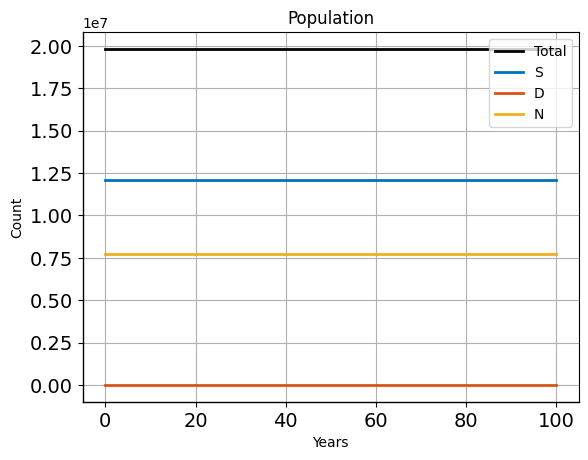

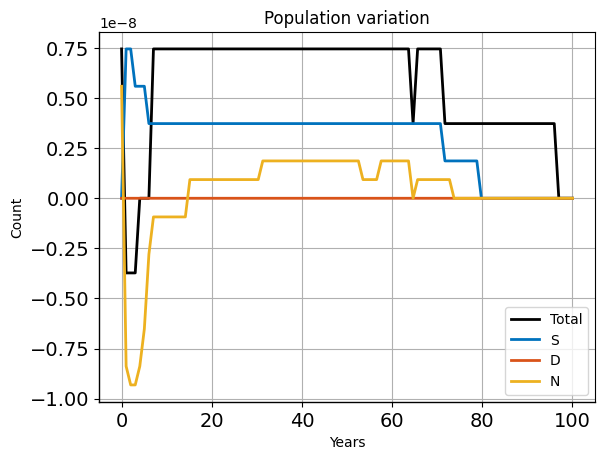

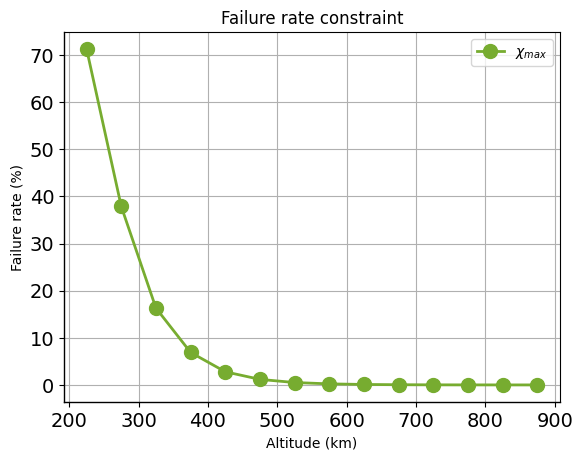

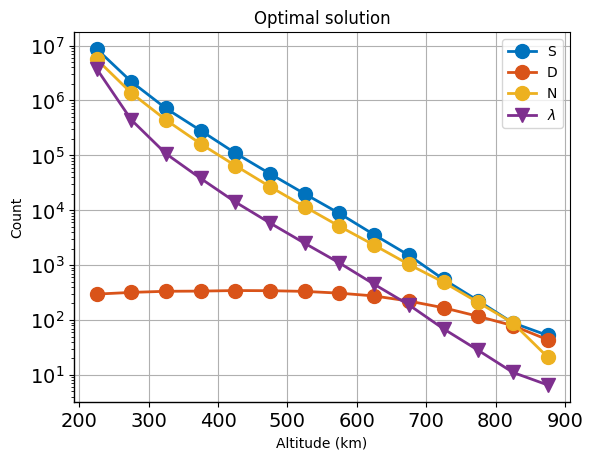

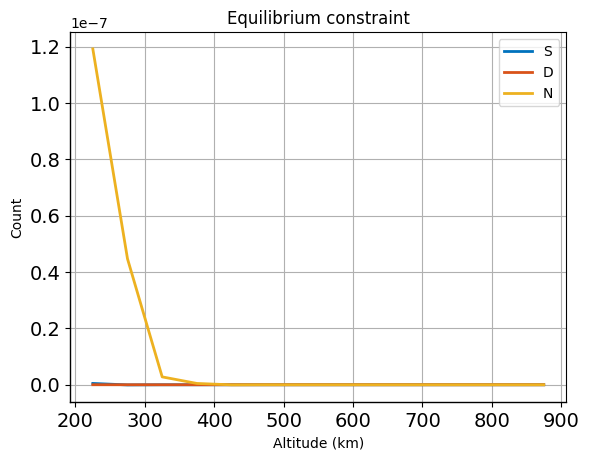

In [18]:
# Plots
colors = [
    [0, 0, 0],
    [0, 0.4470, 0.7410],
    [0.8500, 0.3250, 0.0980],
    [0.9290, 0.6940, 0.1250],
    [0.4940, 0.1840, 0.5560],
    [0.4660, 0.6740, 0.1880],
]
sel_LineWidth = 2
sel_MarkerWidth = 10
sel_LineWidthAxis = 1
sel_FontSize = 14
Dt = 8

plt.figure(facecolor='w')
plt.grid(True)
plt.plot(t_prop, N_tot_sum, color=colors[0], linewidth=sel_LineWidth)
plt.plot(t_prop, S_sum, color=colors[1], linewidth=sel_LineWidth)
plt.plot(t_prop, D_sum, color=colors[2], linewidth=sel_LineWidth)
plt.plot(t_prop, N_sum, color=colors[3], linewidth=sel_LineWidth)
plt.title("Population")
plt.xlabel("Years")
plt.ylabel("Count")
plt.legend(["Total", "S", "D", "N"], loc="best")
plt.gca().tick_params(axis='both', which='major', labelsize=sel_FontSize)
plt.gca().spines['bottom'].set_linewidth(sel_LineWidthAxis)
plt.gca().spines['left'].set_linewidth(sel_LineWidthAxis)
# plt.savefig("so_variation_no_fail.pdf", dpi=300)  

plt.figure(facecolor='w')
plt.grid(True)
plt.plot(t_prop, N_tot_sum[-1] - N_tot_sum, color=colors[0], linewidth=sel_LineWidth)
plt.plot(t_prop, S_sum[-1] - S_sum, color=colors[1], linewidth=sel_LineWidth)
plt.plot(t_prop, D_sum[-1] - D_sum, color=colors[2], linewidth=sel_LineWidth)
plt.plot(t_prop, N_sum[-1] - N_sum, color=colors[3], linewidth=sel_LineWidth)
plt.title("Population variation")
plt.xlabel("Years")
plt.ylabel("Count")
plt.legend(["Total", "S", "D", "N"], loc="best")
plt.gca().tick_params(axis='both', which='major', labelsize=sel_FontSize)
plt.gca().spines['bottom'].set_linewidth(sel_LineWidthAxis)
plt.gca().spines['left'].set_linewidth(sel_LineWidthAxis)
# plt.savefig("so_variation_no_fail.pdf", dpi=300)  

plt.figure(facecolor='w')
plt.grid(True)
# plt.plot(R02[1:] - 25, 100 * failure_rate_U * np.ones_like(R02[1:]), '--', color=colors[0], linewidth=sel_LineWidth)
plt.plot(R02[1:] - 25, 100 * (Dt * lam_opt - S_opt) / (Dt * lam_opt), '-o', color=colors[5], linewidth=sel_LineWidth, markersize=sel_MarkerWidth)
plt.title("Failure rate constraint")
plt.xlabel("Altitude (km)")
plt.ylabel("Failure rate (%)")
plt.legend(["$\chi_{max}$"], loc="best")
plt.gca().tick_params(axis='both', which='major', labelsize=sel_FontSize)
plt.gca().spines['bottom'].set_linewidth(sel_LineWidthAxis)
plt.gca().spines['left'].set_linewidth(sel_LineWidthAxis)
# plt.savefig("fail_rate_no_fail.pdf", dpi=300)  

plt.figure(facecolor='w')
plt.semilogy(R02[1:] - 25, S_opt, '-o', color=colors[1], linewidth=sel_LineWidth, markersize=sel_MarkerWidth)
plt.grid(True)
plt.semilogy(R02[1:] - 25, D_opt, '-o', color=colors[2], linewidth=sel_LineWidth, markersize=sel_MarkerWidth)
plt.semilogy(R02[1:] - 25, N_opt, '-o', color=colors[3], linewidth=sel_LineWidth, markersize=sel_MarkerWidth)
plt.semilogy(R02[1:] - 25, lam_opt, '-v', color=colors[4], linewidth=sel_LineWidth, markersize=sel_MarkerWidth)
plt.title("Optimal solution")
plt.xlabel("Altitude (km)")
plt.ylabel("Count")
plt.legend(["S", "D", "N", "$\lambda$"], loc="best")
plt.gca().tick_params(axis='both', which='major', labelsize=sel_FontSize)
plt.gca().spines['bottom'].set_linewidth(sel_LineWidthAxis)
plt.gca().spines['left'].set_linewidth(sel_LineWidthAxis)
# plt.savefig("max_capacity_no_fail.pdf", dpi=300)  

plt.figure(facecolor='w')
plt.grid(True)
plt.plot(R02[1:] - 25, S_eq, color=colors[1], linewidth=sel_LineWidth)
plt.plot(R02[1:] - 25, D_eq, color=colors[2], linewidth=sel_LineWidth)
plt.plot(R02[1:] - 25, N_eq, color=colors[3], linewidth=sel_LineWidth)
plt.title("Equilibrium constraint")
plt.xlabel("Altitude (km)")
plt.ylabel("Count")
plt.legend(["S", "D", "N"], loc="best")
plt.gca().tick_params(axis='both', which='major', labelsize=sel_FontSize)
plt.gca().spines['bottom'].set_linewidth(sel_LineWidthAxis)
plt.gca().spines['left'].set_linewidth(sel_LineWidthAxis)
# plt.savefig("equil_constr_no_fail.pdf", dpi=300)  


In [422]:
# from scipy.optimize import show_options
# show_options('minimize', method='SLSQP')
# show_options('minimize', method='trust-constr')